In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv('C:/Users/esmaa/python/Dersler/veri madenciliği/modeleHazir_SayisalVeri.csv')

In [3]:
#  property_type ve usageName ve residence_name için label encoding yapılamayacağı için one-hot encoding yapılacak 

# floorName verileri (1. kat, kot 2 vb.) floorNameFloat sütununda sayısal verilere dönüştürüldü
# bulunan_yonler için yon_sayisi ve direction_encoded
# yapiDurumu için yapiDurumu_encoded
# yakit ve isitma arasından yakit sütununa label encoding uyguladık; yakit için yakit_encoded
# registerState için registerState_encoded

# is_outlier_price sızıntıya sebep olur, model buna bakarak kopya çeker. Genelleme özelliğini düşürür çünkü etkisi %60 üzerinde

df = df.drop(columns = ['roomAndLivingRoom', 'price_category', 'price_category', 'area_name', 'county_name', 
                        'sakarya_center_category', 'karasu_category', 'sapanca_category', 'sakarya_university_category',
                        'is_outlier_price',
                        
                        'floorName', 'residence_name', 'usage_name', 'yakit', 'isitma', 'bulunan_yonler', 
                        'yapiDurumu', 'registerState', 'property_type'])

In [4]:
# Tüm bool sütunları 0 ve 1'e çevir
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)


In [5]:
# medyan değeri ile dolduruyoruz
median_value = df['floorNameFloat'].median()
df['floorNameFloat'] = df['floorNameFloat'].fillna(median_value)
print(median_value)

2.0


In [6]:
# floorCount'ta null değerler vardı sonra biz onların tarla, bahçe gibi verilere ait olduğunu fark edip floorCount'una 0 girdik
# ancak daha sonra aykırı değer olma sebeplerinden dolayı bu satırların hepsi kalktı bu yüzden 0 veya null değer yok 
# bölme işleminde sorun çıkmayacak 
# floorNameFloat null değerleri -5 ile doldurulduğu için yeniden floorRatio hesaplaması ile null değer doldurulması yapılacak
df['floorRatio'] = df['floorNameFloat'] / df['floorCountFloat']

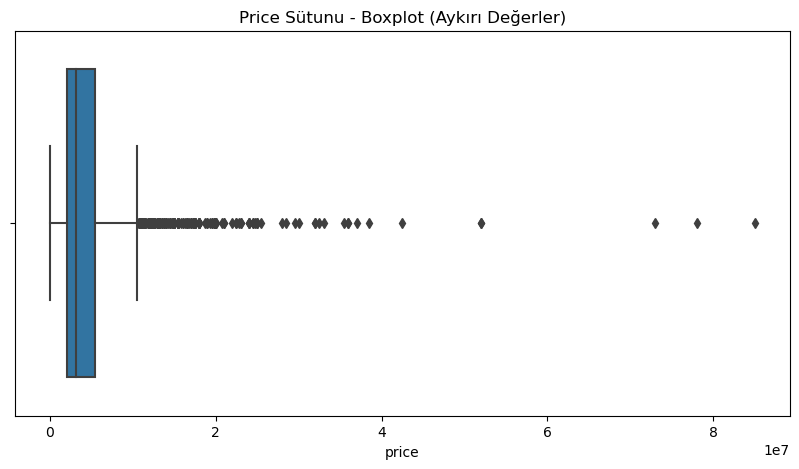

Aykırı değer sayısı: 35

Aykırı Değerler:
        price
37   28500000
222  28000000
239  24000000
250  35500000
339  52000000


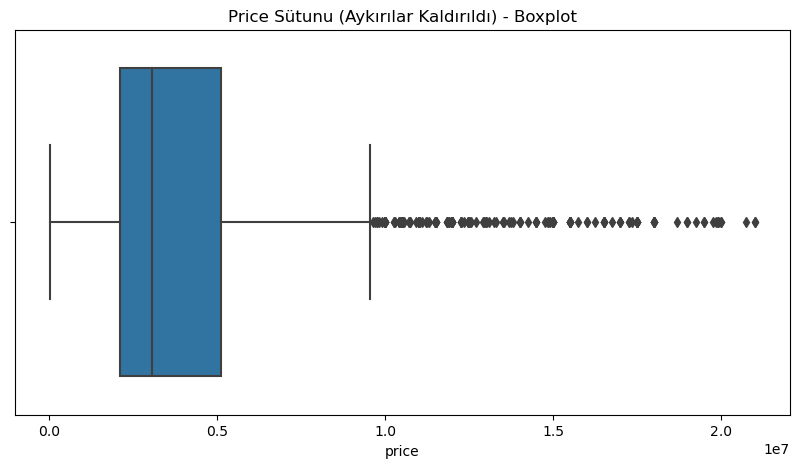


Veri seti satır sayısı - Orijinal: 2154, Temizlenmiş: 2119


In [7]:
# 1. Aykırı Değerleri Görselleştir
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='price')
plt.title("Price Sütunu - Boxplot (Aykırı Değerler)")
plt.show()

# 2. Z-score yöntemiyle aykırı değerleri tespit et
df['price_z'] = zscore(df['price'])

# 3. Aykırı değerleri filtrele
price_outliers = df[(df['price_z'].abs() > 3)]
print(f"Aykırı değer sayısı: {len(price_outliers)}")
print("\nAykırı Değerler:")
print(price_outliers[['price']].head())

# 4. Aykırı değerleri kaldır
df_clean = df[df['price_z'].abs() <= 3].copy()

# 5. Z-score sütununu kaldır
df = df.drop(columns=['price_z'])
df_clean = df_clean.drop(columns=['price_z'])

# 6. Temizlenmiş veride yeniden boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean, x='price')
plt.title("Price Sütunu (Aykırılar Kaldırıldı) - Boxplot")
plt.show()

# 7. Özet
print(f"\nVeri seti satır sayısı - Orijinal: {len(df)}, Temizlenmiş: {len(df_clean)}")


In [8]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# 1. Hedef ve özellik değişkenleri
# -----------------------------
y = df_clean['price']
X = df_clean.drop(columns=['price'])

# -----------------------------
# 2. Eğitim / Test ayırma (%80 eğitim - %20 test)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 3. Log dönüşümü (fiyat çarpıklığını düzeltmek için)
# -----------------------------
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# -----------------------------
# 4. Özellik seçimi: LightGBM ile en önemli 30 özellik
# -----------------------------
lgbm_temp = LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1)
lgbm_temp.fit(X_train, y_train_log)

importances = pd.Series(lgbm_temp.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(30).index.tolist()

X_train_sel = X_train[top_features]
X_test_sel = X_test[top_features]

# -----------------------------
# 5. Hiperparametre aralığı (Randomized Search için)
# -----------------------------
param_dist = {
    'n_estimators': [300, 500],                  # daha uzun öğrenme
    'learning_rate': [0.01, 0.03],               # daha yavaş ve sağlam öğrenme
    'max_depth': [4, 6, 8],                      # sığ ağaçlar (overfitting azaltır)
    'num_leaves': [15, 20, 31],                  # daha az yaprak → ezber azalır
    'min_child_samples': [100, 150],             # her yaprak için en az 100–150 veri → noise engellenir
    'subsample': [0.6, 0.8],                     # tüm veriyi kullanmasın, çeşitlilik artsın
    'colsample_bytree': [0.6, 0.8],              # her ağaç daha az özellik görsün
    'reg_alpha': [0.1, 0.5, 1.0],                # L1 cezası → sadeleşme
    'reg_lambda': [0.1, 0.5, 1.0]                # L2 cezası → ezber önleme
}

# -----------------------------
# 6. Model ve RandomizedSearchCV
# -----------------------------
lgbm = LGBMRegressor(
    random_state=42,
    force_row_wise=True, # önerilen ayar
   
)

kfold = KFold(n_splits=8, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=15,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# -----------------------------
# 7. Modeli eğitim verisiyle eğit
# -----------------------------
random_search.fit(X_train_sel, y_train_log)
best_model = random_search.best_estimator_

# -----------------------------
# 8. Eğitim verisi üzerinde çapraz doğrulama (R² ortalama)
# -----------------------------
cv_scores = cross_val_score(
    best_model, X_train_sel, y_train_log,
    cv=kfold, scoring='r2'
)
r2_cv_mean = cv_scores.mean()

# -----------------------------
# 9. Test verisi üzerinde tahmin ve değerlendirme
# -----------------------------
y_test_pred_log = best_model.predict(X_test_sel)
y_test_pred = np.expm1(y_test_pred_log)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# -----------------------------
# 9B. Eğitim verisi üzerinde doğrudan tahmin ve metrikler
# -----------------------------
y_train_pred_log = best_model.predict(X_train_sel)
y_train_pred = np.expm1(y_train_pred_log)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# -----------------------------
# 9C. Adjusted R² hesaplama
# -----------------------------
def adjusted_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1)) / (n - p - 1)

n_train, p_train = X_train_sel.shape
n_test, p_test = X_test_sel.shape

adj_r2_train = adjusted_r2(r2_train, n_train, p_train)
adj_r2_test = adjusted_r2(r2_test, n_test, p_test)

# -----------------------------

# 10. Sonuçları yazdır
# -----------------------------
print("🌟 En iyi LGBM parametreler:", random_search.best_params_)

print(f"\n📚 Eğitim Verisi Performansı (Doğrudan):")
print(f"RMSE         : {rmse_train:.2f}")
print(f"MAE          : {mae_train:.2f}")
print(f"R²           : {r2_train:.4f}")
print(f"Adjusted R²  : {adj_r2_train:.4f}")

print("\n🧪 Test Verisi Performansı:")
print(f"RMSE         : {rmse_test:.2f}")
print(f"MAE          : {mae_test:.2f}")
print(f"R²           : {r2_test:.4f}")
print(f"Adjusted R²  : {adj_r2_test:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1763
[LightGBM] [Info] Number of data points in the train set: 1695, number of used features: 53
[LightGBM] [Info] Start training from score 15.047525
Fitting 8 folds for each of 15 candidates, totalling 120 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 1700
[LightGBM] [Info] Number of data points in the train set: 1695, number of used features: 30
[LightGBM] [Info] Start training from score 15.047525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

C:\Users\esmaa\AppData\Local\Temp\ipykernel_16516\4066940428.py:41: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


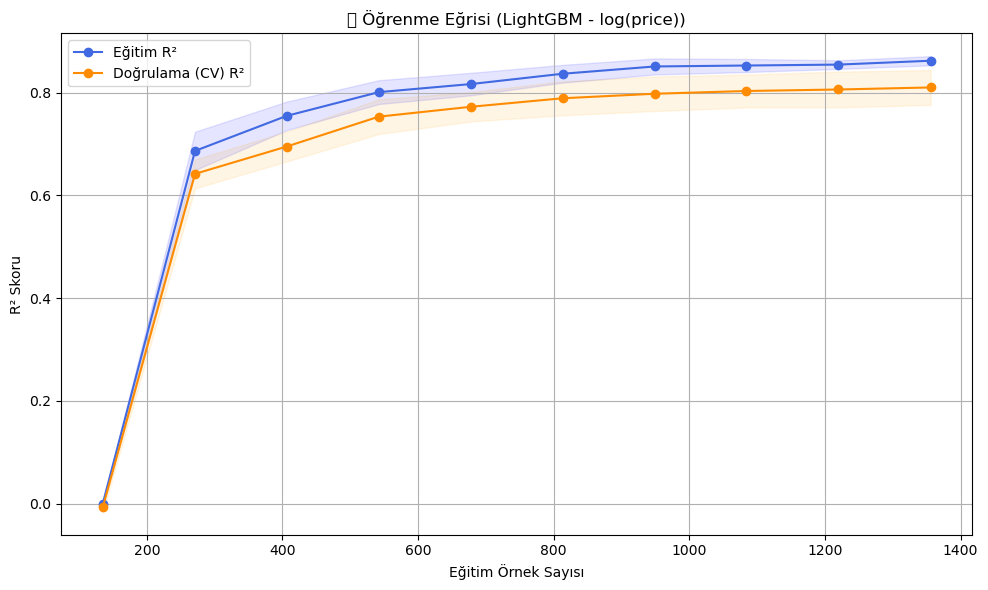

In [9]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Eğitim ve hedef log verisini al
X_lc = X_train_sel
y_lc = y_train_log  # log1p dönüşümlü hedefi kullandık

# Öğrenme eğrisi hesaplama
train_sizes, train_scores, test_scores = learning_curve(
    best_model,                  # En iyi model
    X_lc, y_lc,                  # Eğitim verisi (özellik + log hedef)
    cv=5,                        # 5 katlı çapraz doğrulama
    scoring='r2',                # R² skoruna göre değerlendirme
    n_jobs=-1,                   # Çoklu işlem
    train_sizes=np.linspace(0.1, 1.0, 10),  # Eğitim verisinin %10-100 arası
    shuffle=True,
    random_state=42
)

# Ortalama ve standart sapmaları hesapla
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Grafik çizimi
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Eğitim R²', color='royalblue')
plt.plot(train_sizes, test_mean, 'o-', label='Doğrulama (CV) R²', color='darkorange')

# Hata bantları
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='orange')

# Grafik detayları
plt.title('📈 Öğrenme Eğrisi (LightGBM - log(price))')
plt.xlabel('Eğitim Örnek Sayısı')
plt.ylabel('R² Skoru')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()